In [1]:

!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn


  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/1b/da/24a54b9205fce3bdbaad521c35944d0b0a2d292ac5ae921e484b76312b43/accelerate-0.27.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.7 MB/s eta 0:00:0000:01
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/74/4d/63b033169534f0742b7fe13957118cae08c83b04bfde46511f397872e2e7/datasets-2.17.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow>=12.0.0 from https://files.pythonhosted.org/packages/85/55/636f006d963ddf77270fd294163e149b0719aaaf794de0d023aee88f6335/pyarrow-15.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for pyarrow-hotfix from https://files.pythonhosted.org/packages/e4/f4/9ec2222f5f5f8ea04f66f184caafd991a39c8782e31f5b0266f101cb68ca/pyarrow_hotfix-0.6-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec[http]<=2023.10.0,>=20

In [2]:

!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob
!pip install mlxtend
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall


  Obtaining dependency information for spacy from https://files.pythonhosted.org/packages/21/8f/e67f493b6ae4d359d88fb7e22937749b9b40e2cbed601a2f870d2c94159b/spacy-3.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for spacy-loggers<2.0.0,>=1.0.0 from https://files.pythonhosted.org/packages/33/78/d1a1a026ef3af911159398c939b1509d5c36fe524c7b644f34a5146c4e16/spacy_loggers-1.0.5-py3-none-any.whl.metadata
  Obtaining dependency information for murmurhash<1.1.0,>=0.28.0 from https://files.pythonhosted.org/packages/93/1b/d880be7ac028cab6bf980acf005c16c0ff381f0c0ba1fd60c284626df3fd/murmurhash-1.0.10-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cymem<2.1.0,>=2.0.2 from https://files.pythonhosted.org/packages/e5/bc/761acaf88b1fa69a6b75b55c24fbd8b47dab1a3c414d9512e907a646a048/cymem-2.0.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_6

## Analysiss with pipeline


In [1]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

data=['i love you', 'i hate you']

sentiment_pipeline(data)

2024-02-14 09:47:50.785920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 09:47:50.785965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 09:47:50.787135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 09:47:50.793079: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 09:47:51.669539: W tensorflow/compiler/tf2

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

##  Data Loading and PreProcesing


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import preprocess_kgptalkie as ps
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/IMDB-Dataset.csv")
df = df.sample(5_000)
df.head()



,review,sentiment
29363,After watch this movie I was surprised that so...,negative
1141,This show has to be my favorite out of all the...,positive
28538,Let me tell you something...this movie exceeds...,negative
30979,Andy Lau stars in another cop undercover tale....,negative
2195,"First of all, let me say the I am LDS or rathe...",negative


In [3]:

df.isnull().sum()

review       0
sentiment    0
dtype: int64

## preprocessing

In [4]:
df['word_count'] = df['review'].apply(lambda x : len(x.split()))
df['char_counts']= df['review'].apply(lambda x: len(x))
df['avg_wordlength'] = df['review'].apply(lambda x : ps.get_avg_wordlength(x))
df['stopwords_counts'] = df['review'].apply(lambda x : ps.get_stopwords_counts(x))



In [5]:
df.head()

df['review'] = df['review'].str.lower()
df['reviex']=df['review'].apply(lambda x : ps.remove_html_tags(x))


/home/dima/anaconda3/lib/python3.11/site-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


<Axes: >

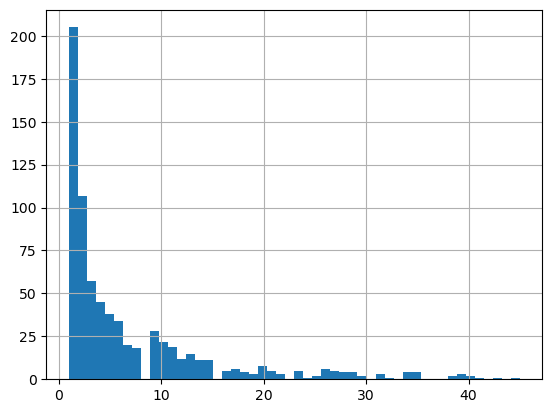

In [6]:
df['word_count'].value_counts().hist(bins=50)


## data Preparation for ML

In [8]:
#custom dataset -> Evaluation/ compute metrics -> traingin arguments -> trainer -> training -> testing

import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


class CustomDataSet(Dataset):
  def __init__(self, texts , labels , tokenizer, max_len=512):
    self.texts = texts
    self.labels =labels
    self.tokenizer = tokenizer
    self.max_len = max_len


  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text= str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation = True , padding = "max_length", max_length = self.max_len)

    return {
        "input_ids": encoding['input_ids'],
        "attention_mask":encoding['attention_mask'],
        'labels':label
    }


In [9]:
#prepare toeknzier and model
from transformers import AutoModelForSequenceClassification, AutoTokenizer

import torch

checkpoint = 'camembert-base'



tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
X = df['review'].tolist()

label2id={'positive' : 1 ,'negative':0}

id2label = {1:'positive' , 0: 'negative'}

y= df['sentiment'].map(label2id).tolist()


dataset = CustomDataSet(X, y ,tokenizer)

In [13]:
dataset[0].keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [11]:
train_dataset, test_dataset  = train_test_split(dataset  , test_size = 0.2 , random_state = 42)

In [13]:

def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak. 
    This is a workaround to avoid storing too many tensors that are not needed.
    """
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

In [18]:
## compute metrics

from sklearn.metrics import accuracy_score , f1_score

def compute_metrics(example):
    labels = example.label_ids
    preds = example.predictions[0]

    f1 = f1_score(labels, preds, average= "weighted")
    acc= accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1':f1
        }

In [22]:
from transformers import TrainingArguments

batch_size = 16
model_name = 'distilbert_finetune_sentiment'

args = TrainingArguments(
    do_train=True,
    do_eval=True,
    output_dir = "output",
    evaluation_strategy="steps",
    eval_steps = 100,   
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    eval_accumulation_steps=1,
    

)

In [23]:
from transformers import Trainer 

trainer = Trainer( model = model,
                   args = args ,
                   train_dataset = train_dataset,
                   eval_dataset= test_dataset,
                   compute_metrics = compute_metrics,
                   tokenizer = tokenizer,
                   preprocess_logits_for_metrics=preprocess_logits_for_metrics
                   
                   )


In [19]:
trainer = 0

In [24]:
trainer.train()

  0%|          | 0/250 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 7.79 GiB of which 16.88 MiB is free. Including non-PyTorch memory, this process has 7.71 GiB memory in use. Of the allocated memory 7.51 GiB is allocated by PyTorch, and 39.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [79]:
trainer.save_model(model_name)

## Model testing

In [1]:
#with pipeline

text = " i'm enjoying this day "

pipe = pipeline('text-classification', model_name)
pipe(text)



NameError: name 'pipeline' is not defined

In [ ]:
# other way



def get_prediction(text):
  tok  = DistilBertTokenizer.from_pretrained(model_name)
  mod = DistilBertSequenceClassification.from_pretrained(model_name)

  input_ids = tok.encode(text,return_rtensor='pt')
  output= mod(input_ids)

  preds = torch.nn.functional.softmax(output.logits, dim =-1)

  prob = torch.max(preds).item()*100

  idx = torch.argmax(preds).item()
  sentiment = id2label[idx]

  return {'sentiment': sentiment,
          'probability': prob}


In [ ]:
text = "i'm enjoying it "
get_prediction(text)

In [25]:
import torch

# Assurez-vous que CUDA est disponible avant de tenter d'accéder aux informations du GPU
if torch.cuda.is_available():
    # Sélectionnez le GPU par son index, 0 par défaut pour le premier GPU
    torch.cuda.set_device(0)

    # Obtenir les informations de mémoire du GPU en octets
    total_memory = torch.cuda.get_device_properties(0).total_memory
    free_memory = torch.cuda.mem_get_info()[0]
    used_memory = total_memory - free_memory

    # Convertir les octets en gigaoctets pour une meilleure lisibilité
    total_memory_gb = total_memory / (1024**3)
    free_memory_gb = free_memory / (1024**3)
    used_memory_gb = used_memory / (1024**3)

    print(f"Mémoire Totale du GPU: {total_memory_gb:.2f} GB")
    print(f"Mémoire Libre du GPU: {free_memory_gb:.2f} GB")
    print(f"Mémoire Utilisée du GPU: {used_memory_gb:.2f} GB")
else:
    print("CUDA n'est pas disponible. Vérifiez votre installation de PyTorch ou les pilotes de votre GPU.")


Mémoire Totale du GPU: 7.79 GB
Mémoire Libre du GPU: 0.02 GB
Mémoire Utilisée du GPU: 7.77 GB


'pynvml module not found, please install pynvml'